# Рекомендательные системы

Вы работаете в крупной компании, занимающейся онлайн-ритейлом (розничными продажами в интернете).

Ваш работодатель хочет увеличить средний чек продаж. Вы знаете, что чем точнее рекомендовать нужный товар пользователю (в нашем случае, товар с более высоким средним чеком), тем выше вероятность покупки этого товара. Простая логика. Мы нашли золото!

## Загрузка модулей

In [5]:
import numpy as np
import pandas as pd
from collections import Counter
import json
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

#from fastai.tabular import *
#from fastai.collab import *
#from fastai.collab import CollabDataBunch


from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
import catboost
import xgboost as xgb
import optuna

### Используемые словари

In [6]:
# Заменяем True/False на 1 и 0
true_false = {True: 1, False: 0}

### Используемые функции

In [7]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() 
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()/2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", va ='center')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def bars_counts(col, df, title_name):
    models = df[col].value_counts().reset_index()[0:25]
    models.columns = [col, 'quantity']
    models[col] = models[col].astype(str)
    plt.rcParams['figure.figsize']=12,10
    ax = sns.barplot(x='quantity', y=col, data=models)
    show_values_on_bars(ax, 'h', 10)
    plt.title(title_name)
    plt.show()

        
def horizontal_barplots(column, data, title_name):
    plt.rcParams['figure.figsize']=12,12
    ax = sns.barplot(x=0, y=column, hue='train', data=data)
    show_values_on_bars(ax, 'h', 10)
    plt.title(title_name)
    plt.show()
    
def vertical_barplots(column, data, title_name):
    plt.rcParams['figure.figsize']=12,12
    ax = sns.barplot(x=0, y=column, data=data)
    show_values_on_bars(ax, 'h', 10)
    plt.title(title_name)
    plt.show()
    
    
def viz_counter_bar(df, column, title, max_values=0, sort_by_index=False):
    """
    Визуализация количества значений в ДФ, Value_counts, 
    горизонтальные столбцы
    df - датафрейм, column - столбец, title - подпись
    max_values - максимальное количество значений для отображения, 0 - все
    sort_by_index - сортирует по индексам, а не значен#иям
    dollars - отображает подписи с $$ для price_range
    """
    if max_values > 0:
        col_values = df[column].value_counts().nlargest(
            max_values).sort_values(ascending=True)
    else:
        col_values = df[column].value_counts(ascending=True)
    
    if sort_by_index: 
        col_values = col_values.sort_index()
    
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (8, 8)
    plt.figure 
    ax = col_values.plot(kind='bar', title=title)
    for i, v in enumerate(col_values):
        plt.text(i, v+(col_values.max()/100), ""+str(v), ha='center', rotation = 'horizontal')
    
    plt.xticks(rotation=0)
    
    plt.show()
    
    
def vertical_boxplots(col_x, col_y, data, title_name, fsize=[16,8]):
    plt.rcParams['figure.figsize']=fsize[0], fsize[1]
    plt.ticklabel_format(style='plain', axis='x')
    ax = sns.boxplot( data=data, orient="v", y=col_x, x=col_y)
    plt.title(title_name)
    plt.show()

def med_price(row):
    """
    Вычисляет среднее между диапазоном цен
    """
    price1, trash, price2 = row['price'].split(' ')
    price = (float(price1) + float(price2)) / 2
    row['price'] = price
    return row

def feature_colon_value(my_list):
    """
    Takes as input a list and prepends the columns names to respective values in the list.
    For example: if my_list = [1,1,0,'del'],
    resultant output = ['f1:1', 'f2:1', 'f3:0', 'loc:del']

    """
    result = []
    aa = my_list
    for x,y in zip(ll,aa):
        res = str(x) +""+ str(y)
        result.append(res)
    return result


def calculate_auc_score(lightfm_model, interactions_matrix, 
                        question_features, professional_features): 
    """
    Measure the ROC AUC metric for a model. 
    A perfect score is 1.0.

    Parameters
    ----------
    lightfm_model: LightFM model 
        A fitted lightfm model 
    interactions_matrix : 
        A lightfm interactions matrix 
    question_features, professional_features: 
        Lightfm features 
        
    Returns
    -------
    String containing AUC score 
    """
    score = auc_score( 
        lightfm_model, interactions_matrix, 
        item_features=item_features, 
        user_features=user_features, 
        num_threads=24).mean()
    return score

## Загрузка данных

In [8]:
for dirname, _, filenames in os.walk('/home/deus99/data'):
#for dirname, _, filenames in os.walk(r'F:\YandexDisk\Skill_Factory\Project6-Recomendations'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/deus99/data/meta_Grocery_and_Gourmet_Food.json
/home/deus99/data/train.csv
/home/deus99/data/test.csv
/home/deus99/data/sample_submission.csv


In [9]:
# Загружаем датасеты
train = pd.read_csv('/home/deus99/data/train.csv', low_memory=False)
test = pd.read_csv('/home/deus99/data/test.csv', low_memory=False)
submission = pd.read_csv('/home/deus99/data/sample_submission.csv', low_memory=False)

# Загружаем датасеты
#train = pd.read_csv(r'F:\YandexDisk\Skill_Factory\Project6-Recomendations\data1\train.csv', low_memory=False)
#test = pd.read_csv(r'F:\YandexDisk\Skill_Factory\Project6-Recomendations\data1\test.csv', low_memory=False)
#submission = pd.read_csv(r'F:\YandexDisk\Skill_Factory\Project6-Recomendations\data1\sample_submission.csv', low_memory=False)

# Постройчно прочитаем json с метаданными и положим результат в датасет "meta"
with open('/home/deus99/data/meta_Grocery_and_Gourmet_Food.json') as f:
    meta_list = []
    for line in f.readlines():
        meta_list.append(json.loads(line))

In [10]:
meta = pd.DataFrame(meta_list)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 22.1+ MB


In [13]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275787 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


## DATA PREPROCESSING

In [14]:
# удаляем дубликаты из json
meta = meta.iloc[meta.astype(str).drop_duplicates().index]

# Удалим дубликаты из тренировочного датасета
train.drop_duplicates(inplace = True)

In [15]:
# Помечаем и объеденяем тренировочный и тестовый датафрейм
train['train'] = 1
test['train'] = 0

df = pd.concat([train, test])

In [16]:
# Преобразование vote в тип int
df['vote'] = df.vote.str.replace(',', '')
df['vote'] = df.vote.fillna(0)
df['vote'] = df.vote.astype(int)

In [17]:
# Объединим  датасет и данные из meta по идентификатору asin (Amazon Standard Identification Number)
df = df.merge(meta, how='left', on='asin')

In [18]:
# максимально чистим память , на счету каждый свободный гиг
del train
del test
del meta

In [19]:
# Меняем ссылки на картинки просто на значение есть или нет
df.loc[df.image_x.isna(), 'image_x'] = 'no'
df.loc[df.image_x!='no', 'image_x'] = 'yes'

df.loc[df.image_y.isna(), 'image_y'] = 'no'
df.loc[df.image_y!='no', 'image_y'] = 'yes'

In [20]:
# изменение размера букв
df['title'] = df.title.apply(lambda x: str(x).lower())

In [21]:
# убираем $ заменяем диапазон цен на среднее значение
df.loc[~df.price.isna(), 'price'] = df.loc[~df.price.isna(), 'price'].apply(lambda x: x.replace('$', ''))
df['price'] = df['price'].apply(lambda x: 0 if x==np.nan else x)

df.loc[(df['price'].str.contains('-')) & (~df['price'].isna())] = df.loc[
    (df['price'].str.contains('-')) & (~df['price'].isna())].apply(med_price, axis=1)

# преобразуем и заполним пропуски
df['price'] = df.price.astype(float)
mean_price = df['price'].mean()
df['price'].fillna(mean_price, inplace=True)
df['price'].fillna(mean_price, inplace=True)
df['price'] = df['price'].round(0)

In [22]:
df.head(1)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,...,main_cat,price,also_buy,image_y,date,feature,details,similar_item,tech1,fit
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,0,NaN,...,Grocery,10.0,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...",yes,NaN,NaN,"\n <div class=""content"">\n\n\n\n\n\n\n<ul...",NaN,NaN,NaN


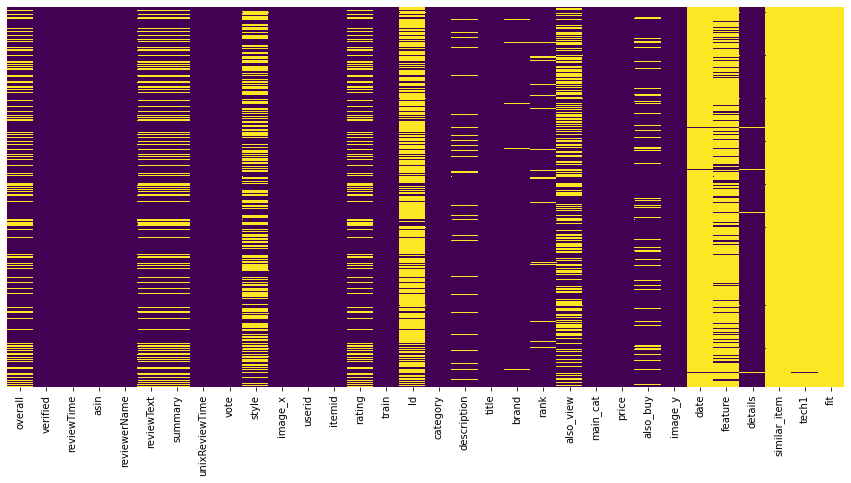

In [23]:
fig, ax = plt.subplots(figsize=(15,7))
sns_heatmap = sns.heatmap(df.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [24]:
df.isna().sum()

overall            285965
verified                0
reviewTime              0
asin                    0
reviewerName          211
reviewText         286239
summary            286131
unixReviewTime          0
vote                    0
style              536983
image_x                 0
userid                  0
itemid                  0
rating             285965
train                   0
Id                 826895
category                0
description         94579
title                   0
brand                8169
rank                46532
also_view          512514
main_cat             1287
price                   0
also_buy           159703
image_y                 0
date              1097246
feature            924095
details             18826
similar_item      1111323
tech1             1107073
fit               1112860
dtype: int64

Столбцы **date**, **feature**, **similar_items**, **tech_1**, **fit** - содержат технические параметры или много пропусков.
**details** - содержит техническую информацию
Это все удаляем.

In [25]:
df.drop(columns=['date', 'feature', 'similar_item', 'tech1', 'fit', 'details'], axis=1, inplace=True)

## EDA

In [26]:
df.sample(5000).describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
overall,3677,NaN,NaN,NaN,4.46125,1.05323,1,4,5,5,5
verified,5000,2,True,4361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewTime,5000,2061,"01 15, 2017",10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asin,5000,3780,B00D3M2QP4,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewerName,4999,4399,Amazon Customer,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
reviewText,3675,3520,good,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summary,3676,2467,Five Stars,774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unixReviewTime,5000,NaN,NaN,NaN,1.44175e+09,5.94271e+07,1.15586e+09,1.41169e+09,1.44824e+09,1.48435e+09,1.53412e+09
vote,5000,NaN,NaN,NaN,0.8142,4.89842,0,0,0,0,261
style,2630,1788,{'Package Type:': ' Standard Packaging'},31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Всего 26 признаков: 4 бинарных, 3 числовых, 13 категориальных, 2 временных ряда.  
*Примечание* - наличие изображений (image_x, image_y) товара будем считать как бинарный признак - есть изображение или нет.   
**train**, **id**, **userid**, **asin** - идентификаторы и рассмотрены не будут

----

#### Числовые признаки  
**overall** - оценка пользователей   
**vote** - число оценок  
**price** - цена товара

---

#### Бинарные признаки  
**verified** - подтвержденный аккаунт  
**image_x** - есть иконка или нет  
**image_y** - есть фотографии изображений или нет (предпросмотр)  
**rating** - понравился товар или нет (1 - да, 0 - нет)   

---

#### Временные ряды
**reviewtime** - дата отзыва  
**unixreviewtime** - время отзыва в формате unix

---

#### Категориальные признаки ( в т.ч. текст)   
**item_id** - id товара (аналог asin)  
**reviewerName** - имя/ник пользователя  
**reviewtext** - полный текст отзыва покупателя  
**summary** - краткий(итоговый) отзыв  от покупателя  
**style** - вид упаковки  
**category** - категория товаров  
**description** - описание товара от производителя  
**title** - полное название (включая производителя и особенность)  
**brand** - Бренд товара  
**rank** - ранк товара  
**main_cat** - основная категория

## Числовые признаки  
### overall - средняя оценка пользователей  

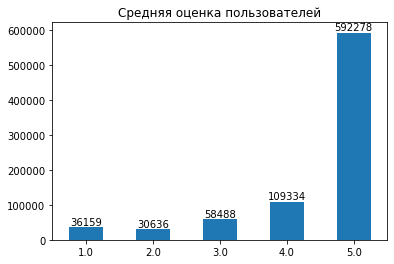

In [27]:
viz_counter_bar(df, 'overall', 'Средняя оценка пользователей', sort_by_index=True)

In [28]:
df[['overall', 'rating']].corr()

,overall,rating
overall,1.000000,0.897241
rating,0.897241,1.000000


Этого признака нет в тестовом датасете, и он почти полностью коррелируется с рейтингом. Потому что, это тот же рейтинг (4 и 5 заменены на 1) Его удалим перед из признаков (в конце), но можно будет использовать при анализе отзывов и пр. Пропусков нет.

In [29]:
# средняя оценка товара
items_score = df[df.train==1].groupby('itemid')['overall'].mean()

### reviewtime и  unixreviewtime - время и дата отзыва

Дата и время отзыва представлена в виде дата время и как юниксовое. Можно удалить один из форматов, например *reviewtime* Но вначале проверим есть ли разница в зависимости от времени. 

In [30]:
df.query('train==1')[['unixReviewTime', 'rating']].corr()

,unixReviewTime,rating
unixReviewTime,1.000000,0.012337
rating,0.012337,1.000000


Корреляция, как и ожидалось, очень низкая. Сложно представить, что есть такие дни, когда товар нравится всем покупателям. Удаляем оба столбца

In [31]:
df.drop(['reviewTime', 'unixReviewTime'], axis=1, inplace=True)

### vote - число оценок

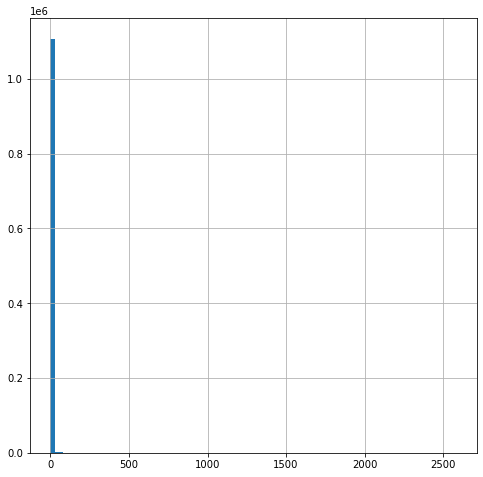

In [32]:
df['vote'].hist(bins=100);

In [33]:
df['vote'].median()

0.0

In [34]:
df['vote'].quantile(0.9)

2.0

In [35]:
df['vote'].max()

2584

In [36]:
df[(df['vote']>0)&(df.train==1)][['vote', 'rating']].corr()

,vote,rating
vote,1.000000,-0.000952
rating,-0.000952,1.000000


В даннои столбце слишком много пропусков (которые были заменены нулями при предобработке), но разницы между большим и малым количеством отзывов почти нет. Так что это столбец также удаляем.

In [37]:
df.drop(['vote'], axis=1, inplace=True)

### price - цена товара

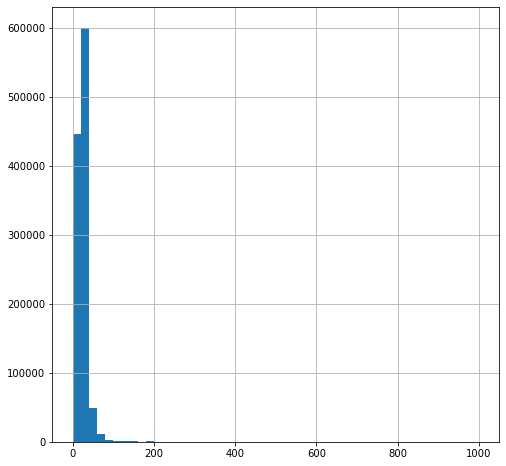

In [38]:
df['price'].hist(bins=50);

Цена 75\% товаров не превышает 22 \\$ при средней цене в 21 \\$. Максимальная цена 470$   
Разобьем товары по ценовым категориям

In [39]:
bins = pd.IntervalIndex.from_tuples([(0, 3), (3, 8), (8, 12), (12, 15), (15, 20), (20, 21), (21, 30), (30, 50), 
                                     (50, 100), (100, 1000)])
df = df.assign(price_range = pd.cut(df['price'], bins))

df.groupby('price_range')['rating'].mean()

price_range
(0, 3]         0.832890
(3, 8]         0.844745
(8, 12]        0.850186
(12, 15]       0.857697
(15, 20]       0.856714
(20, 21]       0.834703
(21, 30]       0.855433
(30, 50]       0.858230
(50, 100]      0.874143
(100, 1000]    0.893118
Name: rating, dtype: float64

Рейтинг дорогих товаров в среднем выше на 10% чем из самой дегевой группы, и примерно на 4-5% выше чем для товаров средней ценовой категории (20-21\\$)

In [40]:
#df['price_range'] = df['price_range'].astype(str)

## Бинарные признаки  
### verified - подтвержденный аккаунт  
Большинство аккаунтов подтверждено, пропусков нет 

In [41]:
df.groupby('verified')['rating'].mean()

verified
False    0.782178
True     0.858530
Name: rating, dtype: float64

Самая частая оценка 5,0 (рейтинг 1,0), но при этом у неподтвержденных аккаунтов оценка в среднем ниже. Заменим значения *True/False* на числовые

In [42]:
df['verified'] = df['verified'].map(true_false)

### image_x - ссылка на картинку (предпросмотр?) 

In [43]:
df.image_x.describe()

count     1112860
unique          2
top            no
freq      1103513
Name: image_x, dtype: object

Конечно это не совсем бинарный признак. Но на оценку товара может влиять отсутвие картинки на сайте. И можно было сделать признак есть или нет картинка у товара. Но здесь 99% пропусков, так что это признак тоже удаляем.

In [44]:
df.drop(['image_x'], axis=1, inplace=True)

### image_y - ссылка на картинки в описании товара

In [45]:
df.query('train==1').groupby('image_y')['rating'].agg(['count', 'mean'])

,count,mean
image_y,,
no,89256,0.842375
yes,737639,0.849230


По среднему значению, разница менее 1%, так что этот столбец тоже удаляем

In [46]:
df.drop(['image_y'], axis=1, inplace=True)

### rating - понравился товар покупателю или нет

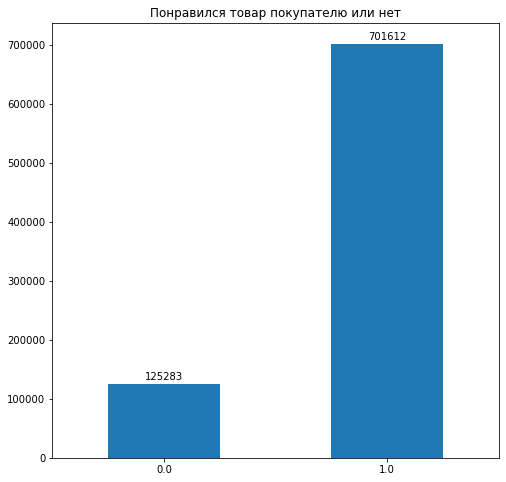

In [47]:
viz_counter_bar(df[df.train==1], 'rating', 'Понравился товар покупателю или нет', sort_by_index=True)

*rating* - целевая переменная, которую нужно предсказать. В тестовом датасете чуть больше 81% товаров получают положительный отзыв

## Категориальные признаки  
### itemid - идентефикатор товара   

Посмотрим на 3 самый популярных id и asin

In [48]:
df.groupby('asin')['rating'].agg(['count', 'mean']).sort_values(by='count', ascending=False).head(3)

,count,mean
asin,,
B00BUKL666,5430,0.884162
B00D3M2QP4,4733,0.886753
B008QMX2SG,4611,0.886359


In [49]:
df.groupby('itemid')['rating'].agg(['count', 'mean']).sort_values(by='count', ascending=False).head(3)

,count,mean
itemid,,
22208,5430,0.884162
23540,4733,0.886753
24556,4611,0.886359


asin и itemid - совпадают, поэтому *asin* - удаляем. Рейтинг не зависит от количество голосов, при большом количесвто оценок, все равно не достигает 1,0  При этом высший рейтинг часто встречается у товаров, где всего 1 голос. Можно создать признак, который будет показывать частоту (популярность) данного товара. 

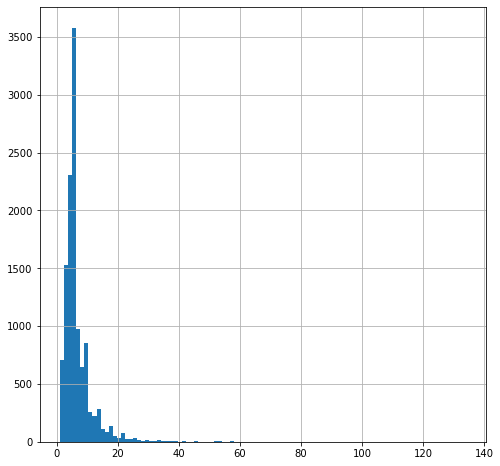

In [50]:
df.groupby('itemid')['rating'].agg(['count', 'mean']).query('mean==1')['count'].hist(bins=100);

In [51]:
#df.drop(['asin'], axis=1, inplace=True)

### reviewerName - имя(ник) обозревателя 

Посмотрим самые распространненые имена в отзывах. Чаще всего это просто покупатель Амазона или Киндл, но их всего 37000, при общем количестве 800 тыс. Также есть 168 пропусков. Имена не уникальные. Например под есть 104 пользователя с именем *Linda*. Можно некоторые имена классифицировать как мужское и женское при помощи NLTK, неопределенные, а также типа customer - создать категорию customer.

In [52]:
df.groupby('reviewerName')['rating'].agg(['count', 'mean']).sort_values(by='count', ascending=False)

,count,mean
reviewerName,,
Amazon Customer,30612,0.861852
Kindle Customer,6012,0.853293
Linda,713,0.896213
John,695,0.851799
David,597,0.857621
...,...,...
...RD,0,NaN
Virginia Lopez,0,NaN
Adaub,0,NaN


### reviewText - текст описания от покупателя  
### Summary - краткое заключение (оценка)  
На Amazon отзывы составляются из двух частей. общая часть (*reviewText*), где покупатель делится впечатлениями и краткая, где краткая оценка или обозначается самый большой недостаток у товара. Здесь стоит отметить, что наиболее часто просто встречается *five stars* - что соответсвует рейтингу (1) , если товар не очень хорош, то можно встретить часто отрицательные частицы например *don't buy* или *not good*.    

10 самых распространненых *summary*

In [53]:
df.groupby(['summary'])['rating'].agg(['count', 'mean']).query('count>100').sort_values(
    by='count', ascending=False).head(10)

,count,mean
summary,,
Five Stars,167416,0.999564
Four Stars,26010,0.999346
Three Stars,11682,0.002739
One Star,5206,0.004418
Two Stars,4824,0.000207
Delicious,3341,0.996408
Yummy,2759,0.995651
Delicious!,2515,0.996421
Great,2103,0.999049


Но в тестовом датасете нет ни одного, ни другого столбца, так что нет смысла их рассматривать

In [54]:
df.drop(['summary', 'reviewText'], axis=1, inplace=True)

### style - вид упаковки, размеры и пр.

In [55]:
df['style'].value_counts().sample(10)

{'Size:': ' Strawberry Extract, (4 fl oz)'}          3
{'Style:': ' Diet Tonic'}                            5
{'Flavor:': ' BBQ Flavored + Pulled Pork'}          10
{'Size:': ' 2.5 Ounce', 'Flavor:': ' Nasty Hot'}    12
{'Flavor:': ' DaHongPao'}                            8
{'Color:': ' Dark Blue Foils'}                       7
{'Flavor:': ' Bacon and Tomato Elbows'}              7
{'Size:': ' 2 oz.', 'Flavor:': ' white truffle'}     1
{'Flavor:': ' Orange Pekoe Decaf - Black'}           1
{'Style:': ' Slow Smoked Original'}                  8
Name: style, dtype: int64

Вряд-ли такой признак как количество в упаковке (1 или несколько товаров) может влиять на итоговую оценку. Теоретически мог повлиять вкус, цвет или другой качественный показатель, но здесь он выряжен неявно. Удаляем.

In [56]:
df.drop(['style'], axis=1, inplace=True)

### category - категория товаров

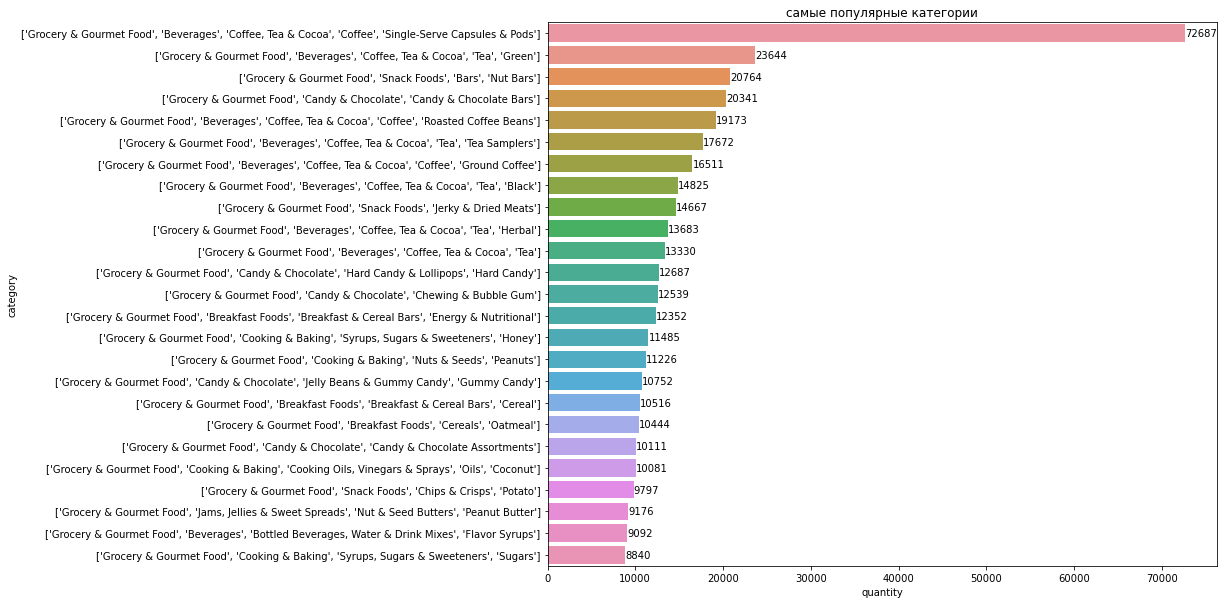

In [57]:
bars_counts('category', df, 'самые популярные категории')

В данном столбце указан путь к товару в классификаторе Амазона. Достаточно выделить только 2 последних шага, чтобы точно определить группу товаров (например чай -> зеленый или черный). Для того, чтобы лучше были ембендинги, предвариетльно (перед редакцией) отсортируем данные по категориям

In [58]:
#df['category'] = df['category'].apply(lambda x: x[-2:])

Посмотрим на десятку худших товаров (количество оценок больше 100) 

In [59]:
df.query('train==1').groupby(df.category.astype(str))['overall'].agg(
    ['count', 'mean']).query('count>100').sort_values(by='mean',ascending=False).tail(10)

,count,mean
category,,
"['Grocery & Gourmet Food', 'Produce', 'Fresh Fruits', 'Bananas & Plantains']",457,3.886214
"['Grocery & Gourmet Food', 'Prepared Foods', 'Deli Salads']",115,3.878261
"['Grocery & Gourmet Food', 'Fresh Flowers & Live Indoor Plants', 'Fresh Cut Flowers', 'Roses']",107,3.869159
"['Grocery & Gourmet Food', 'Canned, Jarred & Packaged Foods', 'Meat, Poultry & Seafood', 'Seafood', 'Caviars & Roes']",346,3.861272
"['Grocery & Gourmet Food', 'Pasta & Noodles', 'Noodles', 'Shirataki']",1339,3.858850
"['Grocery & Gourmet Food', 'Canned, Jarred & Packaged Foods', 'Packaged Meals & Side Dishes', 'Rice Dishes']",319,3.836991
"['Grocery & Gourmet Food', 'Produce', 'Fresh Fruits', 'Avocados']",220,3.818182
"['Grocery & Gourmet Food', 'Produce', 'Fresh Fruits', 'Grapes']",134,3.731343
"['Grocery & Gourmet Food', 'Soups, Stocks & Broths', 'Bisques']",117,3.658120


Можно сразу заметить, что большинство - это свежие продукты - фрукты, цветы или готовый салат. Что является быстропортящимися товарами.

In [60]:
df.query('train==1').groupby(df.category.astype(str))['overall'].agg(
    ['count', 'mean']).query('count>100').sort_values(by='mean',ascending=False).head(10)

,count,mean
category,,
"['Grocery & Gourmet Food', 'Cooking & Baking', 'Cooking Oils, Vinegars & Sprays']",212,4.863208
"['Grocery & Gourmet Food', 'Cooking & Baking', 'Nuts & Seeds', 'Flax Seeds']",436,4.839450
"['Grocery & Gourmet Food', 'Dried Beans, Grains & Rice', 'Peas', 'Split']",105,4.838095
"['Grocery & Gourmet Food', 'Herbs, Spices & Seasonings', 'Salt & Salt Substitutes', 'Coarse Salt']",2548,4.820644
"['Grocery & Gourmet Food', 'Herbs, Spices & Seasonings', 'Single Herbs & Spices', 'Parsley']",329,4.811550
"['Grocery & Gourmet Food', 'Herbs, Spices & Seasonings', 'Single Herbs & Spices', 'Sweet Basil Leaf']",157,4.802548
"['Grocery & Gourmet Food', 'Dried Beans, Grains & Rice', 'Grains & Rice', 'Wheat Berries']",386,4.792746
"['Grocery & Gourmet Food', 'Cooking & Baking', 'Flours & Meals', 'Barley Flour']",495,4.789899
"['Grocery & Gourmet Food', 'Herbs, Spices & Seasonings', 'Pepper & Peppercorns']",306,4.784314


Вверху списка - специи, мука, соль и пр. бакалейные товары, у которых нет проблем со сроком годности.  
Возможно стоит выделить последнюю категории отдельно. 

In [61]:
# где-то категорий меньше, продублируем ее
df['cat1'] = df['category'].apply(lambda x: x[0])
df['cat2'] = df['category'].apply(lambda x: x[1])
df['cat3'] = df['category'].apply(lambda x: x[-2])
df['cat4'] = df['category'].apply(lambda x: x[-1])

### description - описание товара от продавца  
В данном столбце описывается состав, рецептура и пр, то, что есть на упаковке. 

In [62]:
df.iloc[7].description

["Dietary restrictions dont have to stop you from enjoying all of your favorite treats. REESE'S SUGAR FREE Peanut Butter Cups Miniatures have the famous taste of milk chocolate and peanut butter with none of the sugar. Fill your candy dishes with these orange-foiled crowd pleasers, or surprise a friend with a gift bag full of REESE'S SUGAR FREE Peanut Butter Cups Miniatures!",
 'All major allergens are contained and listed as ingredients on our labels. As recommended by Food Allergy and Anaphylaxis Network (FAAN), please check the label on each package before purchasing.',
 'MALTITOL; PEANUTS*; CHOCOLATE*; COCOA BUTTER; LACTITOL (MILK); CELLULOSE GEL; POLYDEXTROSE; VEGETABLE OIL (PEANUT, PALM KERNEL AND PALM OIL); MILK FAT; CONTAINS 2% OR LESS OF: CREAM (MILK)*; SALT; SOY LECITHIN; SODIUM CASEINATE (MILK); PGPR, EMULSIFIER; NATURAL AND ARTIFICIAL FLAVOR; SUCRALOSE; TBHQ (PRESERVATIVE) *ADDS A NEGLIGIBLE AMOUNT OF SUGAR',
 'Statements regarding dietary supplements have not been evaluate

In [63]:
df.query('train==1')[df.description.astype('str').str.contains('sugar free')].overall.value_counts()

<ipython-input-63-06d50ecbfdea>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.query('train==1')[df.description.astype('str').str.contains('sugar free')].overall.value_counts()


5.0    3092
4.0     697
3.0     421
1.0     260
2.0     238
Name: overall, dtype: int64

Возьмем для примера популярное в америке продукты без сахара (*sugar free*). Распределение примерно такое же как и во всем датасете. Многие описания повторяются и это не зависит от оценки. Так что, данный столбец тоже можно удалить.

In [64]:
df.drop(['description'], axis=1, inplace=True)

### title  - название товара

In [65]:
df.query('train==1').groupby('title')['overall'].agg(['count', 'mean']).sort_values(by='count').tail(10)

,count,mean
title,,
"twinings of london christmas black tea bags, 20 count",1541,4.571707
"davidson's tea bulk, anise seed, 16-ounce bag",1882,4.380446
"planters dry roasted peanuts, dry roasted, lightly salted, 16 ounce (pack of 12)",1945,4.539846
"planters peanuts, honey roasted & salted, 52 ounce canister (pack of 2)",1951,4.585853
"twinings of london pure camomile herbal tea bags, 20 count",2126,4.630292
"twinings of london english afternoon black tea bags, 20 count (pack of 6)",2166,4.639889
"kind bars, caramel almond and sea salt, gluten free, 1.4 ounce bars, 12 count",3079,4.531991
"kind bars, madagascar vanilla almond, gluten free, low sugar, 1.4oz",4611,4.580785
"kind bars, dark chocolate chili almond, gluten free, 1.4 ounce bars, 12 count",4733,4.578703


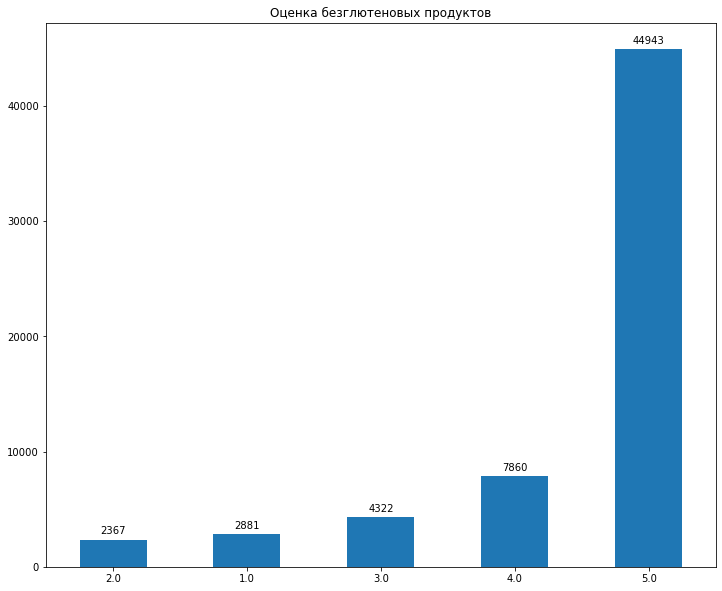

In [66]:
viz_counter_bar(df.query('train==1').loc[df.title.str.contains(
    'gluten free')], 'overall', 'Оценка безглютеновых продуктов')

Продукты без глютена покупаются определенным кругом людей (из-за диетических предпочтений) и такие продукты часто стоят дороже и лучше оцениваются покупателями. 

In [67]:
# создаем признак безглютеновых продуктов
df.loc[(df.title.str.contains('gluten free')), 'gluten_free'] = 1
df.loc[~(df.title.str.contains('gluten free')), 'gluten_free'] = 0

In [68]:
df[['gluten_free']] = df[['gluten_free']].astype(int)

### brand - бренд/производитель

In [69]:
topbrands = df.query('train==1').groupby('brand')['rating'].agg(
    ['count', 'mean']).query('count>50').sort_values(by='mean')

topbrands

,count,mean
brand,,
Just The Cheese,292,0.458904
Cracked Nut Butter,71,0.492958
Compleats,158,0.500000
White Coffee,77,0.519481
Pace,150,0.520000
...,...,...
Get Chia,115,0.982609
Calasparra,67,0.985075
Modernist Pantry,87,0.988506


Здесь не так все однозначно. Часть продуктов от конкретного производителя оценивается высоким рейтингом, а часть нравится только половине. У части производителей мало отзывов (меньше 50), этих производителей заменим на *other brand*

In [70]:
df.loc[df.brand.isin(topbrands.index.tolist()), 'brand'] = 'other brand'

### rank - ранк товара в категории  
Данного столбца нет в тестовом датафрейме - столбец удаляем. А потом создадим опять ))

In [71]:
df.drop(['rank'], axis=1, inplace=True)

### main_cat - основная категория

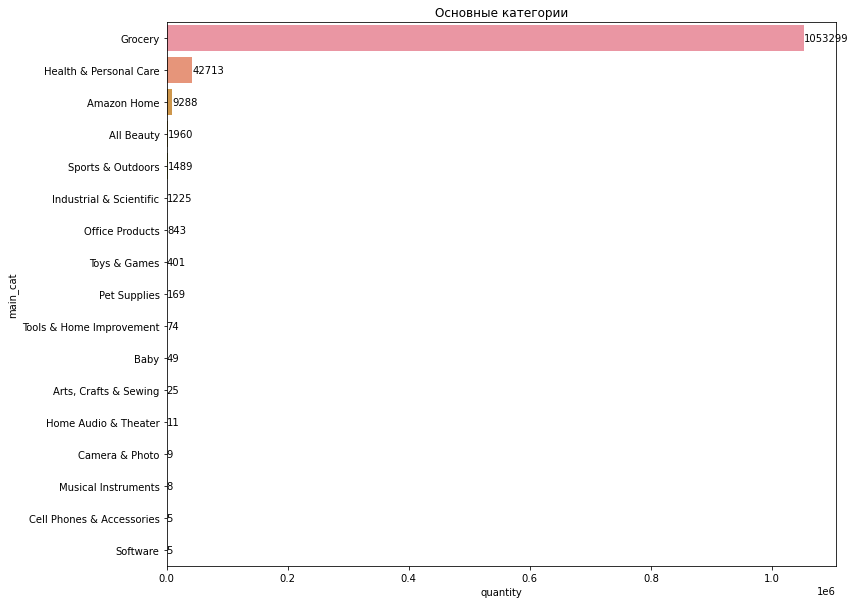

In [72]:
bars_counts('main_cat', df, 'Основные категории')

Во многих категориях мало продуктов, поэтому выделим все, категории с количеством меньше 2000. 

In [73]:
small_cats = df['main_cat'].value_counts().reset_index().query('main_cat<2000')['index'].tolist()

In [74]:
# заменям все непопулярные категории 
df.loc[df.main_cat.isin(small_cats), 'main_cat'] = 'other_cat'

In [75]:
# удаляем ненужное
df.drop(columns=['overall'], axis=1, inplace=True)

In [76]:
goods = df[['itemid', 'category', 'brand', 'price', 'main_cat', 'title']].copy()

In [77]:
# Заполним пропуски
df['brand'] = df['brand'].fillna('otehr_brand')
df['main_cat'] = df['main_cat'].fillna('other_cat')

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1112860 entries, 0 to 1112859
Data columns (total 21 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   verified      1112860 non-null  int64   
 1   asin          1112860 non-null  object  
 2   reviewerName  1112649 non-null  object  
 3   userid        1112860 non-null  int64   
 4   itemid        1112860 non-null  int64   
 5   rating        826895 non-null   float64 
 6   train         1112860 non-null  int64   
 7   Id            285965 non-null   float64 
 8   category      1112860 non-null  object  
 9   title         1112860 non-null  object  
 10  brand         1112860 non-null  object  
 11  also_view     600346 non-null   object  
 12  main_cat      1112860 non-null  object  
 13  price         1112860 non-null  float64 
 14  also_buy      953157 non-null   object  
 15  price_range   1112820 non-null  category
 16  cat1          1112860 non-null  object  
 17  cat2    

Осталось не так много признаков, из которых несколько идентификаторов (**asin, userid, itemid, irain, id**), 2 признака (**also_buy** и **also_view** пропущены, т.к. непонятно, что с ними пока делат, и целевая переменная **rating**. Разделим признаки на 2 группы -  относяшиеся к пользователям:  
**verified** - проверенный или нет аккаунт  
**reviewName** - ник/имя пользователя  

и относящиеся к товарам:  
**category** - категория товаров  
**title** - название товара  
**brand** - бренд  
**price** - цена  или **price_range** - ценовой диапазон


## Построение простой рекомендательной системы  
Для построения используем тренировчный датасет, который еще раз разобьем на обучающую и тестовую выборку

In [79]:
#df = df.sort_values(by=['main_cat','cat1', 'cat2', 'cat3', 'cat4'])

In [80]:
train_data, test_data = train_test_split(df[df.train==1],random_state=32, shuffle=True)

In [81]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

Подбор гиперпараметров осуществляется вручную. 

In [82]:
NUM_THREADS = 24 #число потоков
NUM_COMPONENTS = 40 #число параметров вектора 
NUM_EPOCHS = 25 #число эпох обучения
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
#LOSS_FUNCTION = 'warp'
RANDOM_STATE = 23
LR = 0.05

model = LightFM(learning_rate=0.06, 
                loss=LOSS_FUNCTION,
                no_components=NUM_COMPONENTS, 
                learning_schedule=LEARNING_SCHEDULE,
                random_state = RANDOM_STATE)

model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)
sklearn.metrics.roc_auc_score(test_data.rating, preds)

0.7234691626399712

In [83]:
#test = test.fillna(0)
preds = model.predict(df[df.train==0].userid.values,
                      df[df.train==0].itemid.values)

In [84]:
preds.min(), preds.max()

(-24.694336, 33.92186)

In [85]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
normalized_preds.min(), normalized_preds.max()

(0.0, 1.0)

In [86]:
submission['rating']= normalized_preds
submission.to_csv('submission_log.csv', index=False)

При сабмите на Кагл получили Roc-Auc 0.721, что соответсвует нашей оценке и бейзлайну. Из хороших новостей, оценка  на Кагл не сильно отличается от той, которая получается в ноутбуке, значит алгоритм работает верно)) 

### Обучение на всем датасете   
Проведем обучение на всем тренировочном датасете.

In [87]:
ratings_coo_all = sparse.coo_matrix((df[df.train==1]['rating'].astype(int),
                                 (df[df.train==1]['userid'],
                                  df[df.train==1]['itemid'])))



NUM_THREADS = 24 #число потоков
NUM_COMPONENTS = 160 #число параметров вектора 
NUM_EPOCHS = 25 #число эпох обучения
LEARNING_SCHEDULE = 'adagrad'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 23
LR = 0.05

model = LightFM(learning_rate=LR, 
                loss=LOSS_FUNCTION,
                no_components=NUM_COMPONENTS, 
                learning_schedule=LEARNING_SCHEDULE,
                random_state = RANDOM_STATE)

model = model.fit(ratings_coo_all, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

preds = model.predict(df[df.train==0].userid.values,
                      df[df.train==0].itemid.values)
#sklearn.metrics.roc_auc_score(test.rating, preds)

In [88]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [89]:
submission['rating']= normalized_preds

In [90]:
submission.to_csv('submission_fulltrain.csv', index=False)

Обучение на всем датасете улучшило точность прогноза до 0.7635 (и 19го места на тот момент), но все равно точность недостаточна. Улучшить точность можно за счет решения проблемы холодного старта и построения гибридной рекомендательной системы или использования других алгоритмой

## Feature Engeneering  
Для того, чтобы построить гибридную систему нужно выделить пользовательские признаки и признаки товара. 

### user_feature - пользовательске признаки   
всего признака из EDA которые можно использовать - проверенный аккаунт или нет (**verified**) и **reviewName** - из которого мы выделим пол пользователя

In [91]:
#nltk.download()

In [92]:
from nltk.corpus import names 
import nltk 
import random

def gender_features(word): 
    return {'last_letter':word[-1]} 

usernames = df.reviewerName.value_counts().reset_index()['index'].reset_index()

# удаляем фамилии
usernames['index'] = usernames['index'].apply(lambda x: str(x).split(' ')[0])

# добавляем длину имени
usernames['nl'] = usernames['index'].apply(lambda x: len(x))

# Удяляем имена меньше 3 символов
usernames = usernames.loc[usernames.nl>2]

# удаляем Amazon и Kindle
usernames = usernames.iloc[2::]

# оставляем только столбец name
usernames = usernames[['index']]
usernames.columns = ['name']

# preparing a list of examples and corresponding class labels. 
labeled_names = ([(name, 'male') for name in names.words('male.txt')]+
             [(name, 'female') for name in names.words('female.txt')]) 

# we use the feature extractor to process the names data. 
featuresets = [(gender_features(n), gender)  
               for (n, gender)in labeled_names] 

# Divide the resulting list of feature 
# sets into a training set and a test set. 
train_set, test_set = featuresets[1000:], featuresets[:2000] 

# The training set is used to  
# train a new "naive Bayes" classifier. 
classifier = nltk.NaiveBayesClassifier.train(train_set) 

nn = pd.DataFrame(labeled_names)
nn.columns=['name', 'sex']
nn_males = nn.query('sex=="male"')
nn_females = nn.query('sex=="female"')

usernames['sex'] = usernames['name'].apply(lambda x: 'male' if x in nn_males.name.tolist() else np.nan)

usernames.loc[usernames.sex.isna(), 'sex'] = usernames.loc[
    usernames.sex.isna(), 'name'].apply(lambda x: 'female' if x in nn_females.name.tolist() else np.nan)

usernames.loc[usernames.sex.isna(), 'sex'] = usernames.loc[
    usernames.sex.isna(), 'name'].apply(lambda x: classifier.classify(gender_features(x)))

usernames = usernames.set_index('name')['sex'].to_dict()

df['username'] = df['reviewerName'].apply(lambda x: str(x).split(' ')[0])

df['sex'] = df['username'].map(usernames)

df['sex'].fillna('unisex', inplace=True)

df.loc[df['reviewerName']=='Anonymous', 'sex'] = 'unisex'

Небольшая разница в оценках все-же присутвует

In [93]:
df.groupby('sex')['rating'].mean()

sex
female    0.852851
male      0.844667
unisex    0.839466
Name: rating, dtype: float64

### user-feature

In [94]:
from lightfm.data import Dataset
# we call fit to supply userid, item id and user/item features
dataset1 = Dataset()

In [95]:
features_user = df[df.train==1][['userid', 'verified', 'sex']]

In [96]:
user_f = []
col = []
unique_f1 = []
for column in features_user.drop(['userid'], axis=1):
    col += [column]*len(features_user[column].unique())
    unique_f1 += list(features_user[column].unique())
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    user_f.append(res)
    print(res)

verified:1
verified:0
sex:female
sex:male
sex:unisex


In [97]:
ll = []
for column in features_user.drop(['userid'], axis=1):
    ll.append(column + ':')
print(ll)

['verified:', 'sex:']


In [98]:
ad_subset = features_user.drop(['userid'], axis=1)
ad_list = [x.tolist() for x in ad_subset.values]
user_feature_list = []
for user in ad_list:
    user_feature_list.append(feature_colon_value(user))
print(f'Final output: {user_feature_list[0:5]}')

Final output: [['verified:1', 'sex:female'], ['verified:1', 'sex:female'], ['verified:1', 'sex:male'], ['verified:1', 'sex:male'], ['verified:1', 'sex:male']]


In [99]:
user_tuple = list(zip(features_user.userid, user_feature_list))

### item-feature

In [100]:
df.head(2)

,verified,asin,reviewerName,userid,itemid,rating,train,Id,category,title,...,price,also_buy,price_range,cat1,cat2,cat3,cat4,gluten_free,username,sex
0,1,B01CPNIEQG,Heather,102179,37138,1.0,1,NaN,"[Grocery & Gourmet Food, Herbs, Spices & Seaso...","primal palate organic spices adobo seasoning, ...",...,10.0,"[B01DGZ2B48, B01EZ489AO, B01DH795LM, B01EYW2LC...","(8, 12]",Grocery & Gourmet Food,"Herbs, Spices & Seasonings",Mixed Spices & Seasonings,Adobo Seasoning,0,Heather,female
1,1,B006F63M8U,Linda Odom,3625,17322,1.0,1,NaN,"[Grocery & Gourmet Food, Beverages, Coffee, Te...",milk chocolate swiss miss hot cocoa mix 60-0.7...,...,18.0,"[B001FBKO4U, B00BJ9URYA, B00451ZJB0, B0017TMTF...","(15, 20]",Grocery & Gourmet Food,Beverages,"Coffee, Tea & Cocoa",Cocoa,0,Linda,female


In [101]:
# сохраним список товаров список товаров
goods = df[['itemid', 'main_cat', 'category', 'brand', 'price']].copy()

In [102]:
df_ns = df.copy()

In [103]:
df = df.sort_values(by=['main_cat','cat1', 'cat2', 'cat3', 'cat4'])

In [104]:
df['category'] = df['category'].astype(str)
df['price_range'] = df['price_range'].astype(str)
features_item = df[df.train==1][['itemid', 'category']]

In [105]:
item_f = []
col = []
unique_f1 = []
for column in features_item.drop(['itemid'], axis=1):
    col += [column]*len(features_item[column].unique())
    unique_f1 += list(features_item[column].unique())
for x,y in zip(col, unique_f1):
    res = str(x)+ ":" +str(y)
    item_f.append(res)
    #print(res)

In [106]:
ll = []
for column in features_item.drop(['itemid'], axis=1):
    ll.append(column + ':')
print(ll)

['category:']


In [107]:
ad_subset = features_item.drop(['itemid'], axis=1)
ad_list = [x.tolist() for x in ad_subset.values]
item_feature_list = []
for item in ad_list:
    item_feature_list.append(feature_colon_value(item))
print(f'Final output: {item_feature_list[0:5]}')

Final output: [["category:['Grocery & Gourmet Food', 'Alcoholic Beverages', 'Wine', 'Non-Alcoholic Wine']"], ["category:['Grocery & Gourmet Food', 'Alcoholic Beverages', 'Wine', 'Non-Alcoholic Wine']"], ["category:['Grocery & Gourmet Food', 'Alcoholic Beverages', 'Wine', 'Non-Alcoholic Wine']"], ["category:['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa']"], ["category:['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa']"]]


In [109]:
item_tuple = list(zip(features_item.itemid, item_feature_list))
item_tuple[0:5]

[(16310,
  ["category:['Grocery & Gourmet Food', 'Alcoholic Beverages', 'Wine', 'Non-Alcoholic Wine']"]),
 (16310,
  ["category:['Grocery & Gourmet Food', 'Alcoholic Beverages', 'Wine', 'Non-Alcoholic Wine']"]),
 (16310,
  ["category:['Grocery & Gourmet Food', 'Alcoholic Beverages', 'Wine', 'Non-Alcoholic Wine']"]),
 (16315,
  ["category:['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa']"]),
 (16315,
  ["category:['Grocery & Gourmet Food', 'Beverages', 'Coffee, Tea & Cocoa']"])]

In [110]:
dataset1.fit(
        df['userid'].unique(), # all the users
        df['itemid'].unique(), # all the items
        user_features = user_f,
        item_features = item_f
)

In [111]:
# При построении матриц из полного датасета (todense()) 
#не хватает 32Gb ОЗУ, поэтому в Ubuntu стоит выполнить следующую счтрочку

# $sudo sysctl -w vm.overcommit_memory=1

In [112]:
user_features = dataset1.build_user_features(user_tuple, normalize= True)
user_features.todense()

matrix([[0.06666667, 0.        , 0.        , ..., 0.46666667, 0.        ,
         0.        ],
        [0.        , 0.06666667, 0.        , ..., 0.46666667, 0.        ,
         0.        ],
        [0.        , 0.        , 0.11111111, ..., 0.        , 0.        ,
         0.44444445],
        ...,
        [0.        , 0.        , 0.        , ..., 0.44444445, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.46666667],
        [0.        , 0.        , 0.        , ..., 0.44444445, 0.        ,
         0.        ]], dtype=float32)

In [113]:
item_features = dataset1.build_item_features(item_tuple, normalize= True)
item_features.todense()

matrix([[0.25      , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.16666667, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.03125   , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32)

In [114]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset1.mapping()

In [115]:
df_cut = df[df.train==1][['userid','itemid','rating']]

(interactions, weights) = dataset1.build_interactions([(x[0], x[1], x[2]) for x in df_cut.values ])

In [116]:
NUM_THREADS = 24 # количество ядер/потоков процессора

model2 = LightFM(learning_rate=LR, 
                loss=LOSS_FUNCTION,
                no_components=NUM_COMPONENTS, 
                learning_schedule=LEARNING_SCHEDULE,
                random_state = RANDOM_STATE)





model2.fit(interactions,
      user_features= user_features,
      item_features= item_features,
      sample_weight= weights,
      epochs=15,
      num_threads=NUM_THREADS)

Проверку модели производим при помощи встроенной метрики в *LightFM* roc-auc. Метрика выводит усредненное значение 

In [117]:
calculate_auc_score(model2, interactions, item_features, user_features)

0.6025881

In [118]:
# precision - очень низкое значение (прим.)
precision_at_k( 
        model2, interactions, 
        item_features=item_features, 
        user_features=user_features, 
        num_threads=24, k=5).mean()

0.006154667

По встроенной метрике *roc-auc* незначительно уменьшилась. Но точность прогнозов для пользователей очень низкая. Сделаем прогноза для Kaggle

In [119]:
# mapping
user_ids = df[df.train==0].userid.apply(lambda x: user_id_map[x])
item_ids = df[df.train==0].itemid.apply(lambda x: item_id_map[x])
preds2 = model2.predict(user_ids.values, item_ids.values, user_features=user_features, item_features=item_features)

In [120]:
print('минимальное и максимальное значения: ', preds2.min(), preds2.max())

минимальное и максимальное значения:  0.0028862928 13.771395


In [121]:
# normalize
preds2 = (preds2 - preds2.min()) / (preds2 - preds2.min()).max()

In [122]:
submission['rating']= preds2
submission.to_csv('submission_hybrid.csv', index=False)

Roc-AUc около 0,5 говорит о том, что модель не работает. Ответ может дать распределение *rating* в итоговом submission

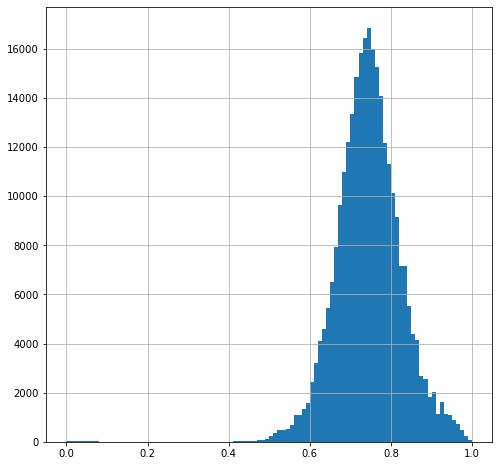

In [123]:
plt.rcParams['figure.figsize'] = (8, 8)
# распределение на модели с user/item - feature
submission['rating'].hist(bins=100);

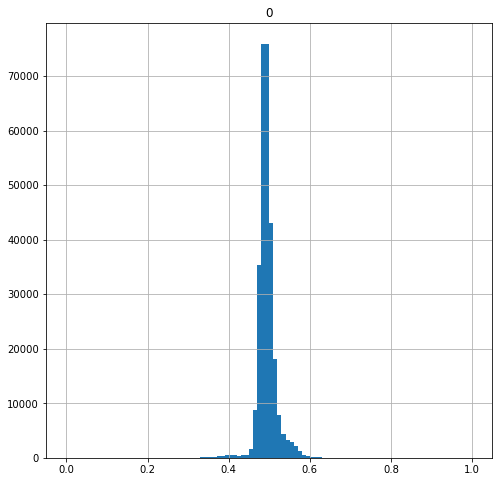

In [124]:
#распределение на простой модели
pd.DataFrame(normalized_preds).hist(bins=100);

### Прогноз с использованием двух моделей  
Для прогноза известных значений используем простую модель, для новых пользователй/товаров - с user/item

In [130]:
known_users = df[df.train==1].userid.tolist()

In [153]:
unknown_ids = df.loc[(df.train==0) & ~(df.userid.isin(known_users)), 'Id'].astype(int).tolist()

In [132]:
preds

array([1.478449  , 1.0139649 , 0.36459944, ..., 0.6442715 , 1.7072457 ,
       2.391864  ], dtype=float32)

In [186]:
sub_blend = pd.DataFrame(normalized_preds, preds2).reset_index()
sub_blend.columns = ['simple', 'feat']

In [188]:
sub_blend['rating'] = sub_blend['simple']
sub_blend.loc[sub_blend.index.isin(unknown_ids), 'rating'] = sub_blend.loc[sub_blend.index.isin(unknown_ids), 'feat']

In [189]:
sub_blend = sub_blend['rating'].reset_index()#.to_csv('sub_hybr3.csv', index=False)

In [190]:
sub_blend.columns = ['Id', 'rating']

In [191]:
sub_blend.to_csv('sub_hybr3.csv', index=False)

In [193]:
sub_blend

,Id,rating
0,0,0.674604
1,1,0.735244
2,2,0.583931
3,3,0.657728
4,4,0.728806
...,...,...
285960,285960,0.711619
285961,285961,0.647706
285962,285962,0.686736
285963,285963,0.745516


Из-за плохих значений user/feature получили слишком большие по модулю значения прогнозов (до нормализации счет мог быть на миллионы), почти все значения оказались около нуля. При то, что на простой модели, большинство было больше 0,5.   
  
Дполонительно построим систему оценки с CATboost.

## CATBoost

### Feature Engeneering 2   
Работа Catboost с фичами отличается от LightFM и поэтому создадим дополнительные фичи.  
На основе столбцов *also_buy* *also_view* создадим популярность товаров, вернем столбец **rank** и создадим дополнительный признак **buy_ratio** - как часто покупатель покупает товар, после просмотра  

*Примечание* Таблица популярности товаров вместе с оценками и признаками понадобится нам далее, поэтому создаем ее сразу

In [195]:
# Считаем наиболее покупаемые (без дубликатов)

items_db = df[['userid', 'asin', 'itemid', 'also_buy', 'also_view']]
# map 
user_asin = items_db[['userid', 'asin']]


buys = items_db[['userid', 'also_buy']].explode('also_buy')
buys.columns = ['userid', 'asin']
most_buys = pd.concat([buys, user_asin]).drop_duplicates()['asin'].value_counts()


# Считаем просмотры
views = items_db[['userid', 'also_view']].explode('also_view')
views.columns = ['userid', 'asin']
most_views = pd.concat([views, user_asin]).drop_duplicates()['asin'].value_counts()

asin_stats = pd.concat([most_buys, most_views], axis=1)
asin_stats.columns = ['buys', 'views']
asin_stats.fillna(0, inplace=True)

# если товар был куплен, значит и просмотрен
asin_stats['views'] = asin_stats['views'] + asin_stats['buys']

# считаем buy_ratio
asin_stats['buy_ratio'] = asin_stats['buys'] / asin_stats['views']
asin_stats = asin_stats.reset_index()
asin_stats.rename({'index': 'asin'}, axis=1, inplace=True)
df = df.merge(asin_stats, how='left', left_on='asin', right_on='asin')

cat_buy_ranking = df.groupby('category')['buys'].rank()
# рейтинг товаров по asin
asins_rating = df[df.train==1].groupby('asin')['rating'].mean()

titles = df[['itemid', 'asin', 'title']].drop_duplicates()

In [196]:
# объеденяем
goods = goods.merge(titles).merge(asin_stats)

# разделяем
goods['sm_cat'] = goods['category'].apply(lambda x: x[-2])
goods['fn_cat'] = goods['category'].apply(lambda x: x[-1])

goods.drop(['category'], axis=1, inplace=True)
# список товаров
goods = goods.drop_duplicates()

# средний рейтинг
goods_rating = df[df.train==1].groupby('itemid')['rating'].mean().reset_index()
goods = goods.merge(goods_rating)

In [197]:
goods

,itemid,main_cat,brand,price,asin,title,buys,views,buy_ratio,sm_cat,fn_cat,rating
0,37138,Grocery,Primal Palate Organic Spices,10.0,B01CPNIEQG,"primal palate organic spices adobo seasoning, ...",14.0,28.0,0.500000,Mixed Spices & Seasonings,Adobo Seasoning,0.875000
1,17322,Grocery,other brand,18.0,B006F63M8U,milk chocolate swiss miss hot cocoa mix 60-0.7...,3252.0,3842.0,0.846434,"Coffee, Tea & Cocoa",Cocoa,0.925373
2,5600,Grocery,other brand,21.0,B00112O8NG,"torani syrup, sugar free vanilla, 25.4 oz",672.0,1344.0,0.500000,"Bottled Beverages, Water & Drink Mixes",Flavor Syrups,0.862481
3,30249,Grocery,other brand,45.0,B00MRAQUM8,frontier herb organic powdered ceylon cinnamon...,294.0,588.0,0.500000,Single Herbs & Spices,Cinnamon,0.928571
4,4349,Grocery,other brand,21.0,B000R7RN0G,miss vickie's jalapeño flavored kettle cooked ...,1233.0,1272.0,0.969340,Chips & Crisps,Potato,0.848485
...,...,...,...,...,...,...,...,...,...,...,...,...
41297,38934,Grocery,Mallo Cup,31.0,B0011MQSSY,boyer milk chocolate mallo cups giant 24 packs,36.0,44.0,0.818182,Candy & Chocolate,Candy & Chocolate Bars,1.000000
41298,38250,Grocery,Peanut Butter Americano,21.0,B01H638D8E,pb americano gourmet crunchy peanut butter – h...,5.0,37.0,0.135135,Nut & Seed Butters,Peanut Butter,1.000000
41299,29571,Grocery,other brand,33.0,B00LKCILI0,starbucks kirkland signature medium roast coff...,347.0,672.0,0.516369,Coffee,Roasted Coffee Beans,1.000000
41300,26244,Health & Personal Care,Genesis Today,21.0,B00GG4E32U,genesis today white mulberry tea - 45 tea bags,6.0,12.0,0.500000,Tea,Tea Samplers,1.000000


In [198]:
# Подготовка данных
#df.drop(['asin'], axis=1, inplace=True)
df.drop(['title'], axis=1, inplace=True)
df.drop(['reviewerName'], axis=1, inplace=True)
df.drop(['username'], axis=1, inplace=True)

In [199]:
df = pd.concat([df, cat_buy_ranking], axis=1)
df.columns.values[-1] = 'rank'

In [200]:
df['buys'] = df['buys'].apply(lambda x: np.log(x+1))
df['views'] = df['views'].apply(lambda x: np.log(x+1))
df['rank'] = df['rank'].apply(lambda x: np.log(x+1))

In [201]:
df.drop(['buys', 'views'], axis=1, inplace=True)

In [202]:
df['category'] = df['category'].astype(str)
df['price_range'] = df['price_range'].astype(str)
cat_cols = ['verified', 'userid', 'itemid', 'category', 'brand', 'main_cat', 'sex', 'price_range']
num_cols = ['price', 'buys', 'views', 'rank', 'buy_ratio']
test_data = df[df.train==0].drop(['Id', 'rating', 'train', 'also_buy', 'also_view'], axis=1)
X = df[df.train==1].drop(['Id', 'rating', 'train', 'also_view', 'also_buy'], axis=1)
y = df[df.train==1]['rating'].values

In [203]:
df.head(2)

,verified,asin,userid,itemid,rating,train,Id,category,brand,also_view,...,also_buy,price_range,cat1,cat2,cat3,cat4,gluten_free,sex,buy_ratio,rank
0,1,B005MRMOAU,99650,16310,1.0,1,NaN,"['Grocery & Gourmet Food', 'Alcoholic Beverage...",MY SANCTUARY,"[B00VF6FFXU, B00AH5AOUE, B00HZ5RO16, B00HZ41ZS...",...,"[B00HZ41ZS0, B00VF6FFXU, B00HZ5RO16, B00HYMU88...","(21.0, 30.0]",Grocery & Gourmet Food,Alcoholic Beverages,Wine,Non-Alcoholic Wine,0,female,0.369565,2.014903
1,1,B005MRMOAU,59993,16310,0.0,1,NaN,"['Grocery & Gourmet Food', 'Alcoholic Beverage...",MY SANCTUARY,"[B00VF6FFXU, B00AH5AOUE, B00HZ5RO16, B00HZ41ZS...",...,"[B00HZ41ZS0, B00VF6FFXU, B00HZ5RO16, B00HYMU88...","(21.0, 30.0]",Grocery & Gourmet Food,Alcoholic Beverages,Wine,Non-Alcoholic Wine,0,female,0.369565,2.014903


In [204]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 826895 entries, 0 to 1112857
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   verified     826895 non-null  int64  
 1   asin         826895 non-null  object 
 2   userid       826895 non-null  int64  
 3   itemid       826895 non-null  int64  
 4   category     826895 non-null  object 
 5   brand        826895 non-null  object 
 6   main_cat     826895 non-null  object 
 7   price        826895 non-null  float64
 8   price_range  826895 non-null  object 
 9   cat1         826895 non-null  object 
 10  cat2         826895 non-null  object 
 11  cat3         826895 non-null  object 
 12  cat4         826895 non-null  object 
 13  gluten_free  826895 non-null  int64  
 14  sex          826895 non-null  object 
 15  buy_ratio    826895 non-null  float64
 16  rank         826895 non-null  float64
dtypes: float64(3), int64(4), object(10)
memory usage: 113.6+ MB


In [205]:
#X.drop(['also_view', 'also_buy'], axis=1, inplace=True)
X.drop(['asin'], axis=1, inplace=True)

In [206]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42)

In [207]:
# Убираем из списка столбцов, числовые переменные, оставляем только категорийные
cat_features = set(X.columns).difference(set(num_cols))

In [208]:
cat_features

{'brand',
 'cat1',
 'cat2',
 'cat3',
 'cat4',
 'category',
 'gluten_free',
 'itemid',
 'main_cat',
 'price_range',
 'sex',
 'userid',
 'verified'}

In [209]:
y = y.reshape(-1,1)

In [210]:
# Функция подготовки модели и расчета метрики для Optuna 

from catboost import Pool
import sklearn.metrics
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X, y, 
                                                        test_size=0.2, random_state=RANDOM_SEED)
    train_pool = Pool(train_x, train_y, cat_features=cat_features)
    test_pool = Pool(test_x, test_y, cat_features=cat_features)

    
    params = {
        'iterations' : trial.suggest_int('iterations', 300, 2500),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.2),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    model = CatBoostRegressor(**params, task_type='GPU', eval_metric='AUC', verbose=0)
    #model = CatBoostClassifier(**params)
    model.fit(train_pool)
    preds = model.predict(test_pool)
    pred_labels = np.rint(preds)
    #preds = preds.T[1]
    accuracy = sklearn.metrics.roc_auc_score(test_y, preds)
    return 1-accuracy

In [213]:
# проводти подбор гиперпараметров для модели при помощи Optuna 
# В ноутбуке может стоять значение n_trials = 5, но при расчетах лучше ставить 50-100 
# поддержка GPU (на новых видеокартах) обязательна task_type=GPU в функции выше

RANDOM_SEED = 42

import optuna
if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective, n_trials=10)
    print(study.best_trial)

[I 2021-01-17 15:59:54,831] A new study created in memory with name: no-name-89b5d6b4-9231-4d4c-aa4b-0a9afdda64f0
[I 2021-01-17 16:00:26,777] Trial 0 finished with value: 0.26633093021019394 and parameters: {'iterations': 378, 'depth': 5, 'learning_rate': 0.012143294687013485, 'random_strength': 45, 'bagging_temperature': 0.26721828411520354, 'od_type': 'IncToDec', 'od_wait': 42}. Best is trial 0 with value: 0.26633093021019394.
[I 2021-01-17 16:01:03,962] Trial 1 finished with value: 0.2588729730842301 and parameters: {'iterations': 400, 'depth': 10, 'learning_rate': 0.02531855326546179, 'random_strength': 89, 'bagging_temperature': 0.027161700498847145, 'od_type': 'IncToDec', 'od_wait': 33}. Best is trial 1 with value: 0.2588729730842301.
[I 2021-01-17 16:01:43,976] Trial 2 finished with value: 0.25941398918932734 and parameters: {'iterations': 559, 'depth': 4, 'learning_rate': 0.04398163324973404, 'random_strength': 91, 'bagging_temperature': 3.3317886698470773, 'od_type': 'IncToDec

FrozenTrial(number=8, value=0.2572036207871913, datetime_start=datetime.datetime(2021, 1, 17, 16, 10, 58, 331014), datetime_complete=datetime.datetime(2021, 1, 17, 16, 12, 2, 266616), params={'iterations': 835, 'depth': 10, 'learning_rate': 0.01599237992247561, 'random_strength': 59, 'bagging_temperature': 22.089389224264117, 'od_type': 'IncToDec', 'od_wait': 47}, distributions={'iterations': IntUniformDistribution(high=2500, low=300, step=1), 'depth': IntUniformDistribution(high=10, low=4, step=1), 'learning_rate': LogUniformDistribution(high=0.2, low=0.01), 'random_strength': IntUniformDistribution(high=100, low=0, step=1), 'bagging_temperature': LogUniformDistribution(high=100.0, low=0.01), 'od_type': CategoricalDistribution(choices=('IncToDec',)), 'od_wait': IntUniformDistribution(high=50, low=10, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=8, state=TrialState.COMPLETE)


In [214]:
study.best_params

{'iterations': 835,
 'depth': 10,
 'learning_rate': 0.01599237992247561,
 'random_strength': 59,
 'bagging_temperature': 22.089389224264117,
 'od_type': 'IncToDec',
 'od_wait': 47}

In [215]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(task_type='GPU',
                          iterations=835,
                          learning_rate=0.015,
                          depth=10,
                          random_state=42,
                          random_strength=59,
                          bagging_temperature=22.08,
                          eval_metric='AUC',
                          od_type='IncToDec',
                          od_wait=47,
                          od_pval=0.002,
                          l2_leaf_reg=1,
                          subsample=0.75)
    model.fit(X_train, y_train,
              cat_features=cat_features,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)

    return(model)

In [216]:
X_sub = df[df.train==0].drop(['rating', 'Id', 'train'], axis=1)
X_sub.drop(['also_view', 'also_buy', 'asin'], axis=1, inplace=True)

In [218]:
#X_sub.drop(['asin'], axis=1, inplace=True)

In [219]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

submissions = pd.DataFrame(0,columns=["sub_1"], index=submission.index) # куда пишем предикты по каждой модели
score_ls = []
N_FOLDS = 5
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=47).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    #test_predict = test_predict.T[1]
    test_score = sklearn.metrics.roc_auc_score(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold ROC-AUC: {sklearn.metrics.roc_auc_score(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_sub)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')
#'''

  0%|          | 0/5 [00:00<?, ?it/s]

1 Fold ROC-AUC: 0.745


 20%|██        | 1/5 [01:34<06:19, 94.81s/it]

2 Fold ROC-AUC: 0.742


 40%|████      | 2/5 [03:06<04:41, 93.76s/it]

3 Fold ROC-AUC: 0.745


 60%|██████    | 3/5 [04:40<03:08, 94.01s/it]

4 Fold ROC-AUC: 0.739


 80%|████████  | 4/5 [06:13<01:33, 93.61s/it]

5 Fold ROC-AUC: 0.744


100%|██████████| 5/5 [07:46<00:00, 93.39s/it]

Mean Score: 0.743
Std Score: 0.0020
Max Score: 0.745
Min Score: 0.739


In [292]:
submissions['rating'] = submissions.mean(axis=1)
submissions = submissions[['rating']]
submissions = submissions.reset_index()
submissions.columns = ['Id', 'rating']

submissions.to_csv('sub_cat_norm.csv', index=False)
sub_max = submissions['rating'].max()
sub_min = submissions['rating'].min()
submissions['rating'] = (submissions['rating'] - sub_min) / (sub_max - sub_min)
submissions

,Id,rating
0,0,0.882391
1,1,0.857173
2,2,0.798121
3,3,0.704975
4,4,0.812337
...,...,...
285960,285960,0.868333
285961,285961,0.671633
285962,285962,0.686636
285963,285963,0.892972


<AxesSubplot:>

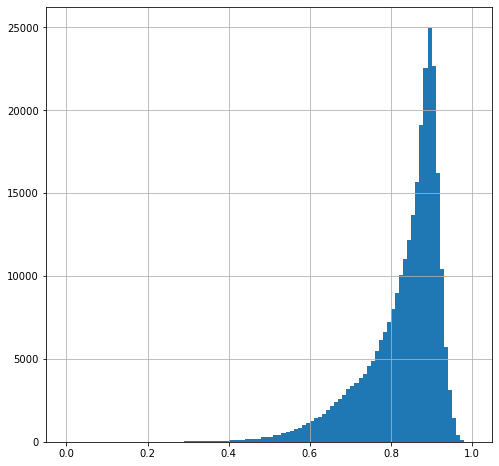

In [293]:
submissions['rating'].hist(bins=100)

In [294]:
submissions.to_csv('sub_catv3.csv', index=False)

## Промежуточные выводы.   
*Catboost* отработал лучше, чем *LightFM*. Итоговый score 0.78785 и 3е место (на момент написания проекта). По распределению *rating* видно, что оценки смещены больше к 0.9 - это объясняется, тем что используем регриссионную модель, а не классификатор (прим. классификатор показал результат хуже).  

Модель LightFM с *user/feature* несмотря на высокую оценку **Roc-Auc** - 0.76, показала  очень низкую **precision**  0.01. После нормализации, почти все оценки оказались около 0, сказалась слишком большая разница между значениями и особенно максимальное значение (т.к. оно учавствует в данной формуле).

## Построение рекомендательной системы

In [451]:
cats = df[df.train==1].sort_values(by=['main_cat', 
                                       'cat3', 'cat4'])[['itemid', 'category']] # категории, а не коты

In [452]:
cats_ind = cats.category.value_counts().reset_index().reset_index().drop(['category'], axis=1)

In [453]:
cats_ind.columns = ['cat_ind', 'category']
cats = cats.drop_duplicates()
cats = cats.merge(cats_ind)

In [454]:
feature_ratings  = sparse.coo_matrix(([1]*len(cats),(cats.itemid,cats.cat_ind)))

In [455]:
#Создаём модель
model3 = LightFM(learning_rate=0.05, loss='warp', no_components=NUM_COMPONENTS)

In [456]:
#Обучаем модель
model3 = model3.fit(interactions, epochs=NUM_EPOCHS, num_threads=NUM_THREADS, item_features=feature_ratings)

In [457]:
item_biases, item_embeddings = model3.get_item_representations(features = feature_ratings)

In [458]:
import nmslib

# Создаём наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')

# Начинаем добавлять наши книги в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

#Вспомогательная функция для поиска по графу
def nearest_items_nms(item_id, index, n=12):
    nn = index.knnQuery(item_embeddings[item_id], k=n)
    return nn

### Оценка работы системы.   
С точки зрения бизнеса стояла конкретная задача, увеличить средний чек. Наша система будет рекомендовать похожие товары, но которые лучше продаются или являются лучшими по оценке. Для этого у нас есть 2 параметра: **buy_ratio** - конверсия, количество покупок / количество просмотров и **rating** - средний, и отвечает за оценку пользователей. 
У двух оценок, есть одна проблема. Товары у которых много продаж и просмотров, могут иметь оценку суть ниже. Товары, которые продались несколько раз, могут иметь высокий рейтинг (в т.ч. накрученный). Среднее значение не подходит, т.к. может "вытянуть" товары с несколькими продажами и еще с нулевой оценкой. Поэтому будем использовать гармоничную метрику, типа *f1*, которая учитывает оба параметра и уберет нулевые значения

In [459]:
goods['f1_score'] = goods['rating'] * goods['buy_ratio'] * 2 / (goods['rating'] + goods['buy_ratio'])

### Проверка работы системы на примерах .   
Ищем похожие элементы и рекомендуем лучшие (5 товаров)
#### 1. Черный чай

In [460]:
goods[goods.itemid==500]

,itemid,main_cat,brand,price,asin,title,buys,views,buy_ratio,sm_cat,fn_cat,rating,f1_score
8180,500,Grocery,other brand,21.0,B00028MO04,"choice organic northwest blackberry tea, 20 co...",88.0,176.0,0.5,Tea,Black,0.814286,0.619565


In [461]:
# Ищем похожие id=500
nbm = nearest_items_nms(500,nms_idx)[0]

In [462]:
goods[goods.itemid.isin(nbm)].sort_values(by='f1_score', ascending=False).head(5)

,itemid,main_cat,brand,price,asin,title,buys,views,buy_ratio,sm_cat,fn_cat,rating,f1_score
17765,34595,Grocery,other brand,21.0,B0117QSD8G,mango black flavored black tea by teavana,231.0,236.0,0.978814,Tea,Black,1.000000,0.989293
22054,1271,Grocery,other brand,15.0,B000CQIDJM,stash tea decaf earl grey tea 18 count tea bag...,1013.0,1040.0,0.974038,Tea,Black,0.958333,0.966122
25626,27690,Grocery,other brand,17.0,B00INK4ON8,stash tea loose leaf ruby orange ginger 1 poun...,67.0,87.0,0.770115,Tea,Black,0.823529,0.795927
17776,48,Grocery,other brand,9.0,B0000CH4GM,"decaffeinated ceylon tea, loose tea in 4 ounce...",337.0,489.0,0.689162,Tea,Black,0.833333,0.754421
24896,0,Grocery,other brand,13.0,4639725183,lipton yellow label finest blend tea bags 100 ...,97.0,163.0,0.595092,Tea,Black,1.000000,0.746154


На первом месте среди рекомендаций оказался чай, который купили 98% пользователей, из тех кто просматривал. Рейтинг 1.0. Очень хорошо.

In [485]:
asins = goods[['asin','itemid']].set_index('asin').to_dict()['itemid']

#### 2. Рис (в пакетах) 

In [463]:
# Ищем похожие id=1251
nbm = nearest_items_nms(2500,nms_idx)[0]

In [464]:
goods[goods.itemid==2500]

,itemid,main_cat,brand,price,asin,title,buys,views,buy_ratio,sm_cat,fn_cat,rating,f1_score
31591,2500,Grocery,other brand,30.0,B000H27I4C,"dynasty maifun rice stick, 6.75-ounce bags (pa...",28.0,202.0,0.138614,Pasta & Noodles,Noodles,1.0,0.243478


In [465]:
goods[goods.itemid.isin(nbm)].sort_values(by='f1_score', ascending=False).head(5)

,itemid,main_cat,brand,price,asin,title,buys,views,buy_ratio,sm_cat,fn_cat,rating,f1_score
25555,34860,Grocery,Asian Best,21.0,B012U8CWDC,"asian best premium rice stick noodle, 16 oz (3...",1657.0,2020.0,0.820297,Pasta & Noodles,Noodles,1.00000,0.901278
38529,36184,Grocery,MARUTAI,5.0,B018QB3G64,marutai kyusyu speciality kagoshima berkshire ...,558.0,681.0,0.819383,Pasta & Noodles,Noodles,1.00000,0.900726
24561,40511,Grocery,other brand,8.0,B00I5BBWBC,la choy chow mein noodles asian cuisine 5oz (2...,68.0,111.0,0.612613,Pasta & Noodles,Noodles,1.00000,0.759777
10518,25380,Grocery,Sea Tangle,21.0,B00FAWW24U,sea tangle kelp noodles 1 pound,59.0,94.0,0.627660,Pasta & Noodles,Noodles,0.62963,0.628643
23183,34925,Grocery,other brand,21.0,B013DSYR3Q,"nissin premium sriracha chow mein noodles, 32 ...",8.0,16.0,0.500000,Pasta & Noodles,Noodles,0.80000,0.615385


На втором месте среди рекомендаций оказалась лапша, рис на первом. Но результат тоже хороший - его покупают 82% пользователей и оценка = 1.0. Попадаение лапши не случайно, в данном датасете и категории, нет разделения на рис, лапшу и пр. Можно выделить рис и лапшу отдельно, результат будет лучше. 

In [479]:
goods[goods.itemid.isin(nbm)].sort_values(by='f1_score', ascending=False).head(5)

[38693, 9649, 10029, 26801, 5614]

#### 3. Дерево Бонсай.   
В датасете много продовольственных товаров, поэтому проверим на подбор цветка в горшке - маленького дерева Бонсай.

In [466]:
goods[goods.itemid==91]

,itemid,main_cat,brand,price,asin,title,buys,views,buy_ratio,sm_cat,fn_cat,rating,f1_score
1233,91,Amazon Home,other brand,21.0,B0000DG86X,brussel's live green mound juniper outdoor bon...,26.0,80.0,0.325,Live Indoor Plants,Bonsai,0.818182,0.465209


In [467]:
# Ищем похожие id=1251
nbm = nearest_items_nms(91,nms_idx)[0]

In [468]:
goods[goods.itemid.isin(nbm)].sort_values(by='f1_score', ascending=False).head(5)

,itemid,main_cat,brand,price,asin,title,buys,views,buy_ratio,sm_cat,fn_cat,rating,f1_score
32473,98,Amazon Home,other brand,21.0,B0000DGG8B,brussel's live fringe flower outdoor bonsai tr...,78.0,99.0,0.787879,Live Indoor Plants,Bonsai,0.750000,0.768473
10874,11083,Amazon Home,Joebonsai,10.0,B002U93T7U,var apagestart = (new date()).gettime();\nvar ...,7.0,14.0,0.500000,Live Indoor Plants,Bonsai,1.000000,0.666667
32709,9421,Amazon Home,Costa Farms,20.0,B001QHKMB8,costa farms ficus bonsai live indoor tabletop ...,131.0,274.0,0.478102,Live Indoor Plants,Bonsai,1.000000,0.646914
2570,3692,Grocery,other brand,21.0,B000NEAKJY,red anthurium hawaiian volcano rock bonsai - g...,9.0,18.0,0.500000,Live Indoor Plants,Bonsai,0.777778,0.608696
19957,95,Amazon Home,other brand,21.0,B0000DGF9V,brussel's live golden gate ficus indoor bonsai...,423.0,597.0,0.708543,Live Indoor Plants,Bonsai,0.500000,0.586279


С деревом сложнее, но система и здесь справилась. На первом месте дерево которое покупают 79% пользователей, рейтинг не сильно высокий 0,75. Но в выборку попали и деревья с рейтингом 1,0 и если судить по количеству продаж, это новый товар. Тоже можно считать хорошим результатом. 

In [471]:
# пакуем эмбендинги
import pickle
with open('asin_embeddings.pickle', 'wb') as file:
    pickle.dump(item_embeddings, file, protocol=pickle.HIGHEST_PROTOCOL)

In [476]:
goods.to_csv('goods.csv', index=False)

## Выводы.  
Были построены несколько моделей: LightFM - простая, LightFM с user/feature, модель CAtboost.  
Catboost лучше всего предсказал результат рейтинга, но не намного 0,78 против 0,76. LightFM проще использовать для целевой задачи - рекомендации товаров. Модель с user/feature очень чувствительна к качеству данных, ROC-AUC оказался около 0,5. Она могла предсказать оценку новых пользвателей или рекомендации, но таких пользователей всего 0,5% в тестовых данных.  

Лучший результат (*Catboost*) - 0.78785 и третье место в таблице на Kaggle.

----

Далее была построена модель с item-feature для рекмомендации подобных товаров, которые выбирает/просматривает пользователь. Вместо рейтинга, количества покупок или конверсии - используется средняя гормоничная метрика. На тестовых примерах показала хороший и работоспособный результат. Также можно улучшить работу системы, если изменить классификацию товара, добавить еще один уровень (как в случае рис/лапша). 